In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [ ]:
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Paths to specific class datasets
PATH_CYST = '/content/drive/Shareddrives/For_Research_S/GAN/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/'
PATH_STONE = '/content/drive/Shareddrives/For_Research_S/GAN/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/'
PATH_TUMOR = '/content/drive/Shareddrives/For_Research_S/GAN/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/'

In [ ]:
# Example: Print number of images in the Cyst class
images = os.listdir(PATH_CYST)
print(f'There are {len(images)} images in the Cyst class.')

There are 3709 images in the Cyst class.


In [ ]:
batch_size = 32
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization for grayscale (1 channel)
])

In [ ]:
from torch.utils.data import Dataset, DataLoader
# Custom dataset class
class SingleClassDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image  # Return only the image since there's only one class

# Load dataset using the custom class
train_data = SingleClassDataset(PATH_CYST, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

print("Dataset loaded successfully!")

Dataset loaded successfully!


In [ ]:
# Define the Generator class for grayscale images (1 channel)
class Generator(nn.Module):
    def __init__(self, nz=128, channels=1):  # 1 channel for grayscale
        super(Generator, self).__init__()
        self.nz = nz
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0),  # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()  # Output layer with Tanh for normalization between -1 and 1
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

# Define the Discriminator class for grayscale images (1 channel)
class Discriminator(nn.Module):
    def __init__(self, channels=1):  # 1 channel for grayscale
        super(Discriminator, self).__init__()
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1),
            *convlayer(128, 256, 4, 2, 1),
            *convlayer(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, 4, 1, 0),  # Output a single value
            nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
# Initialize the models
netG = Generator().to(device)
netD = Discriminator().to(device)

In [ ]:
# Define loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
# Noise vector size
nz = 128

# Training the model
num_epochs = 5
real_label = 1.
fake_label = 0.

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Add an extra dimension for the number of channels
        real_images = real_images.unsqueeze(1)

        # Forward pass real batch through D
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Generate fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)

        # Forward pass fake batch through D
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}]')

    # Save generated images for the last epoch
    if epoch == num_epochs - 1:
        for i in range(1700):  # Generate 3700 images for the cyst class
            noise = torch.randn(1, nz, 1, 1, device=device)
            with torch.no_grad():
                generated_image = netG(noise).detach().cpu()

            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            # Save each image separately
            save_path = f'/content/drive/Shareddrives/For_Research_S/GAN/Generated_Images/Cyst/generated_image_{i+1}.png'
            vutils.save_image(generated_image, save_path, normalize=True)

        print(f'All 3700 images have been saved to: {save_path}')

Epoch [1/5]
Epoch [2/5]
Epoch [3/5]
Epoch [4/5]
Epoch [5/5]
All 3700 images have been saved to: /content/drive/Shareddrives/For_Research_S/GAN/Generated_Images/Cyst/generated_image_1700.png


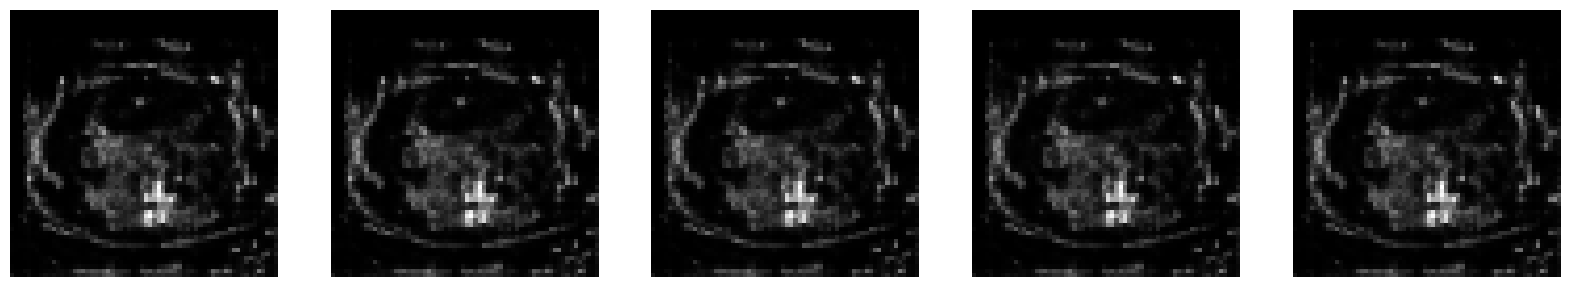

In [ ]:
# Display sample images after the last epoch
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

def plot_generated_images(image_path, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        img = mpimg.imread(f'{image_path}/generated_image_{i+1}.png')
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()

# Example to plot the first 5 images generated
plot_generated_images('/content/drive/Shareddrives/For_Research_S/GAN/Generated_Images/Cyst', 5)